# Смена директории

In [1]:
%cd ..

/Users/uzumnasiya/HSE/Year_Project


# Импорт библиотек

In [2]:
import logging
import warnings


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import joblib
import shap
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from catboost import CatBoostClassifier


from utils.dev_utils import get_pool
from utils.pipeline_utils import CustomPreprocessor
from utils.metrics import MetricCalculator, metric_funcs
from utils.style.styler import style_metrics
from utils.style.html_output import print_multiple_html
from utils.plot_utils import plot_gini_by_period_styled, plot_roc_by_masks

In [3]:
logging.getLogger().setLevel(logging.WARNING)
warnings.filterwarnings('ignore')
sns.set_palette('bright')


pd.options.display.float_format = "{:.2f}".format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [4]:
%load_ext autoreload
%autoreload 2
%aimport utils.plot_utils
%aimport utils.eda_utils
%aimport utils.style_utils
%aimport utils.psi
%aimport utils.style.styler

# Входные данные

## Загрузка данных

In [5]:
data = pd.read_parquet('./data/processed/data.pqt')

data.shape

(1097231, 494)

## Валидные переменные

In [6]:
path = r'./docs/valid_features.xlsx'
valid_features_data = pd.read_excel(path, index_col=False)

## Конфиги/константы

In [7]:
TARGET = 'target'
DATE_MONTH = 'date_month'
DATE_QUARTAL = 'date_quartal'

# Берем порог отсечения по gini - 0.3
FEATURES = valid_features_data.loc[
    (valid_features_data['valid_flag'] == 1) & 
    ((valid_features_data['iv'] > 0.9) | (valid_features_data['gini'].isna()))]['attribute'].values
CAT_FEATURES = list(set(FEATURES) & set(data.select_dtypes(include=["object", "category"]).columns))
NUM_FEATURES = list(set(FEATURES) & set(data.select_dtypes(include=["number"]).columns))

TRAIN_MASK = (data['sample_type'] == 'TRAIN')
TEST_MASK = (data['sample_type'] == 'TEST')
OOT_MASK = (data['sample_type'] == 'OOT')

DEV_MASK = (data['competition_sample_type'] == 'TRAIN')

In [8]:
print_multiple_html(
    ('Кол-во переменных: ', len(FEATURES)),
    ('Кол-во категориальных переменных: ', len(CAT_FEATURES))
)

In [9]:
metr_funcs = {
    'roc_auc': metric_funcs.roc_auc_score_nan,
    'gini': metric_funcs.gini_score_nan,
    'precision': metric_funcs.precision,
    'recall': metric_funcs.recall
}

stats_funcs = {
    'obs_cnt': lambda y_true, data: len(y_true),
    'target_cnt': lambda y_true, data: sum(y_true),
    'DR': lambda y_true, data: sum(y_true) / len(y_true)
}

# Класс для расчета метрик
metr_calc = MetricCalculator(metr_funcs=metr_funcs, stats_funcs=stats_funcs)


STYLE_CONFIG = {
    'percent_cols': ['gini', 'roc_auc', 'DR', 'precision', 'recall'],
    'int_cols': ['obs_cnt', 'target_cnt'],
    'gradient_cols': ['gini', 'roc_auc', 'precision', 'recall'],
    'gradient_cmap': 'RdYlGn',
}

In [10]:
def metrics_split(data, group_cols, metr_calc, pred_cols=['lg_model_preds'], target='target', asc=True):
    """Упрощенный интерфес для расчета метрик"""

    metr_split = metr_calc.calculate(data, true_col=target, pred_cols=pred_cols, group_cols=group_cols)
    metr_split = (
        metr_split
        .sort_values(by=group_cols, ascending=asc)
        .set_index(group_cols)
    )
    
    return metr_split

# Обучение LogReg

In [11]:
default_params = {
    'penalty': 'l1',
    'dual': False,
    'tol': 0.0001,
    'C': 1.0,
    'fit_intercept': True,
    'intercept_scaling': 1,
    'solver': 'saga',
    'max_iter': 100,
    'random_state': 42,
}


preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), NUM_FEATURES),
        ('cat', CatBoostEncoder(), CAT_FEATURES),
    ], 
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(**default_params))
])

pipeline.fit(data.loc[TRAIN_MASK][FEATURES], data.loc[TRAIN_MASK][TARGET])

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [12]:
data['lg_model_preds'] = pipeline.predict_proba(data[FEATURES])[:, 1]

In [13]:
# Выводим топ-20
model_from_pipeline = pipeline.named_steps['model']

coef_df_scaling = pd.DataFrame({
    'feature': FEATURES,
    'coef': abs(model_from_pipeline.coef_[0])
})

coef_df_scaling.sort_values(by='coef', ascending=False).head(20)

,feature,coef
24,V201,2.63
29,V257,0.98
18,V155,0.89
26,V243,0.58
1,card4,0.46
22,V188,0.45
4,R_emaildomain,0.40
14,V148,0.40
17,V154,0.39
7,M3,0.35


## Метрики

In [14]:
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='lg_model_preds',
    group_cols='sample_type',
    metr_calc=metr_calc,
    asc=False
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
sample_type,,,,,,,,
TRAIN,lg_model_preds,73.9%,47.7%,83.9%,15.7%,350 849,12 166,3.5%
TEST,lg_model_preds,73.3%,46.6%,84.6%,15.3%,150 365,5 383,3.6%
OOT,lg_model_preds,73.6%,47.1%,87.5%,16.6%,89 326,3 114,3.5%


In [15]:
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='lg_model_preds',
    group_cols=DATE_MONTH,
    metr_calc=metr_calc,
    asc=True
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
date_month,,,,,,,,
2020-01,lg_model_preds,72.1%,44.1%,72.4%,13.5%,134 339,3 401,2.5%
2020-02,lg_model_preds,76.5%,52.9%,90.4%,17.6%,86 467,3 469,4.0%
2020-03,lg_model_preds,75.1%,50.2%,88.4%,16.3%,95 121,3 832,4.0%
2020-04,lg_model_preds,74.3%,48.5%,83.1%,16.9%,98 615,3 898,4.0%
2020-05,lg_model_preds,71.8%,43.5%,86.6%,13.2%,86 672,2 949,3.4%
2020-06,lg_model_preds,73.4%,46.8%,86.9%,16.5%,86 572,2 995,3.5%
2020-07,lg_model_preds,78.3%,56.5%,100.0%,20.2%,2 754,119,4.3%


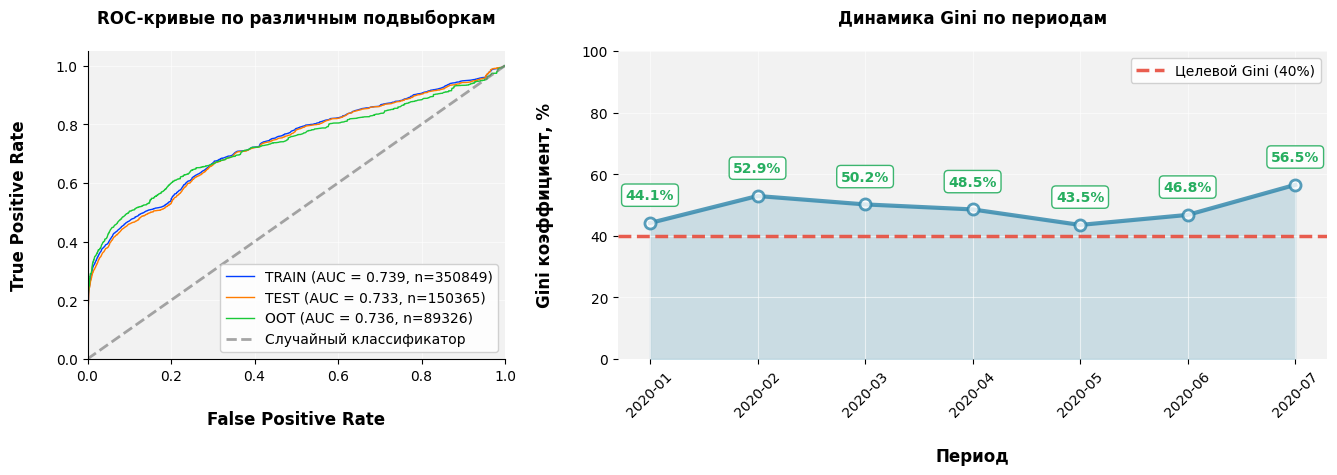

In [16]:
# Графики распределения таргета по выборкам
fig, axes = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1.7]})
masks_dict = {'TRAIN': TRAIN_MASK, 'TEST': TEST_MASK, 'OOT': OOT_MASK}

ax = axes[0]
plot_roc_by_masks(data, TARGET, 'lg_model_preds', masks_dict, 
                     figsize=(8, 4), palette='bright', 
                     title='ROC-кривые по различным подвыборкам',
                     ax=ax)

ax = axes[1]
plot_gini_by_period_styled(metr_split.reset_index(), 'gini', DATE_MONTH,
                              figsize=(8, 4), 
                              target_gini=40,
                              title='Динамика Gini по периодам',
                              ax=ax)

# Обучение KNN

In [ ]:
default_params = {
    'n_neighbors': 100,          # Количество ближайших соседей для классификации
    'weights': 'uniform',      # Все соседи имеют одинаковый вес при голосовании
    'metric': 'manhattan',     # Используется манхэттенское расстояние (L1-норма)
    'algorithm': 'kd_tree',    # Алгоритм для построения пространственного индекса
    'leaf_size': 200,           # Минимальный размер листа в дереве (точки прекращения разбиения)   
    'p': 1,                    # Для manhattan (p=1)     
    
}

knn_model = KNeighborsClassifier(**default_params)

# knn_model.fit(dev_sample.loc[TRAIN_MASK], data.loc[TRAIN_MASK][TARGET])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=10)),    
    ('model', knn_model)
])

In [18]:
pipeline.fit(data.loc[TRAIN_MASK][FEATURES], data.loc[TRAIN_MASK][TARGET])

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
data.loc[DEV_MASK, 'knn_model_preds'] = pipeline.predict_proba(data.loc[DEV_MASK][FEATURES])[:, 1]

## Метрики

In [ ]:
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='knn_model_preds',
    group_cols='sample_type',
    metr_calc=metr_calc,
    asc=False
)

style_metrics(metr_split, STYLE_CONFIG)

In [ ]:
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='knn_model_preds',
    group_cols=DATE_MONTH,
    metr_calc=metr_calc,
    asc=True
)

style_metrics(metr_split, STYLE_CONFIG)

In [ ]:
# Графики распределения таргета по выборкам
fig, axes = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1.7]})
masks_dict = {'TRAIN': TRAIN_MASK, 'TEST': TEST_MASK, 'OOT': OOT_MASK}

ax = axes[0]
plot_roc_by_masks(data, TARGET, 'knn_model_preds', masks_dict, 
                     figsize=(8, 4), palette='bright', 
                     title='ROC-кривые по различным подвыборкам',
                     ax=ax)

ax = axes[1]
plot_gini_by_period_styled(metr_split.reset_index(), 'gini', DATE_MONTH,
                              figsize=(8, 4), 
                              target_gini=40,
                              title='Динамика Gini по периодам',
                              ax=ax)

# Обучение SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Параметры SVM для задачи аномалий
default_params = {
    'C': 1.0,             
    'kernel': 'rbf',           
    'gamma': 'scale',
    'class_weight': 'balanced',  
    'probability': True,
    'random_state': 42,
}


# Создаем SVM модель
svm_model = SVC(**default_params)

# Пайплайн
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=10)),
    ('model', svm_model)
])

pipeline.fit(data.loc[TRAIN_MASK][FEATURES], data.loc[TRAIN_MASK][TARGET])

In [ ]:
data.loc[DEV_MASK, 'svm_model_preds'] = pipeline.predict_proba(data.loc[DEV_MASK][FEATURES])[:, 1]

## Метрики

In [ ]:
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='lg_model_preds',
    group_cols='sample_type',
    metr_calc=metr_calc,
    asc=False
)

style_metrics(metr_split, STYLE_CONFIG)

In [ ]:
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='lg_model_preds',
    group_cols=DATE_MONTH,
    metr_calc=metr_calc,
    asc=True
)

style_metrics(metr_split, STYLE_CONFIG)

In [ ]:
# Графики распределения таргета по выборкам
fig, axes = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1.7]})
masks_dict = {'TRAIN': TRAIN_MASK, 'TEST': TEST_MASK, 'OOT': OOT_MASK}

ax = axes[0]
plot_roc_by_masks(data, TARGET, 'lg_model_preds', masks_dict, 
                     figsize=(8, 4), palette='bright', 
                     title='ROC-кривые по различным подвыборкам',
                     ax=ax)

ax = axes[1]
plot_gini_by_period_styled(metr_split.reset_index(), 'gini', DATE_MONTH,
                              figsize=(8, 4), 
                              target_gini=40,
                              title='Динамика Gini по периодам',
                              ax=ax)